## TensorFlow Decision Forests (TF-DF) 
TF-DF is a collection of Decision Forest (DF) algorithms available in TensorFlow. Decision Forests work differently than Neural Networks (NN): DFs generally do not train with backpropagation, or in mini-batches.

Read more at: https://www.tensorflow.org/decision_forests/migration

## Loading Data

In [1]:
!pip install tensorflow_decision_forests wurlitzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
import tensorflow_decision_forests as tfdf
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [3]:
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.2.0


In [4]:
df = pd.read_csv("/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv")
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## Data preprocessing

In [5]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [7]:
label = "booking_status"

classes = df[label].unique().tolist()
print(f"Label classes: {classes}")

df[label] = df[label].map(classes.index)

Label classes: ['Not_Canceled', 'Canceled']


In [8]:
df = df.iloc[:,1:]

In [9]:
def split_dataset(dataset, test_ratio=0.15):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(df)
print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

30807 examples in training, 5468 examples for testing.


In [10]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

tfdf can handle categorical data automatically

## Training

Check available models in tfdf

In [11]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

Lets use Gradient Boosted Model

In [12]:
model = tfdf.keras.GradientBoostedTreesModel()
model.fit(train_ds)

Use /tmp/tmphvdh3dvv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:06.415363. Found 30807 examples.
Training model...
Model trained in 0:00:21.297440
Compiling model...


[INFO 2023-03-03T18:07:18.156835448+00:00 kernel.cc:1214] Loading model from path /tmp/tmphvdh3dvv/model/ with prefix f84c1f542d1e4138
[INFO 2023-03-03T18:07:18.221321918+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-03-03T18:07:18.221484613+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Performance Metrics

In [13]:
model.compile(metrics=["accuracy","AUC","Precision","Recall"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

6/6 [==============================] - 1s 43ms/step - loss: 0.0000e+00 - accuracy: 0.8947 - auc: 0.9535 - precision: 0.8648 - recall: 0.8016

loss: 0.0000
accuracy: 0.8947
auc: 0.9535
precision: 0.8648
recall: 0.8016


Lets plot the tree decision structure

In [14]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

As we used .summary() with neural networks to check the architecture of the network here in tfdf we can use summary to see different stats like variable importance, loss, different attributes ar each depth of tree and training logs of the model 

In [15]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (17):
	arrival_date
	arrival_month
	arrival_year
	avg_price_per_room
	lead_time
	market_segment_type
	no_of_adults
	no_of_children
	no_of_previous_bookings_not_canceled
	no_of_previous_cancellations
	no_of_special_requests
	no_of_week_nights
	no_of_weekend_nights
	repeated_guest
	required_car_parking_space
	room_type_reserved
	type_of_meal_plan

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                            "lead_time"  0.304807 ################
    2.                   "avg_price_per_room"  0.276320 ############
    3.               "no_of_special_requests"  0.224664 ######
    4.       

This summary can be very long to read so one can also use inspector method to print everything individually

In [16]:
model.make_inspector().features()

["arrival_date" (1; #1),
 "arrival_month" (1; #2),
 "arrival_year" (1; #3),
 "avg_price_per_room" (1; #4),
 "lead_time" (1; #5),
 "market_segment_type" (4; #6),
 "no_of_adults" (1; #7),
 "no_of_children" (1; #8),
 "no_of_previous_bookings_not_canceled" (1; #9),
 "no_of_previous_cancellations" (1; #10),
 "no_of_special_requests" (1; #11),
 "no_of_week_nights" (1; #12),
 "no_of_weekend_nights" (1; #13),
 "repeated_guest" (1; #14),
 "required_car_parking_space" (1; #15),
 "room_type_reserved" (4; #16),
 "type_of_meal_plan" (4; #17)]

In [17]:
model.make_inspector().variable_importances()

{'INV_MEAN_MIN_DEPTH': [("lead_time" (1; #5), 0.30480720019970514),
  ("avg_price_per_room" (1; #4), 0.27631993942298405),
  ("no_of_special_requests" (1; #11), 0.2246641731562634),
  ("arrival_month" (1; #2), 0.2177282199696448),
  ("arrival_date" (1; #1), 0.19420330107094946),
  ("no_of_week_nights" (1; #12), 0.19217432409131854),
  ("market_segment_type" (4; #6), 0.19199496938992028),
  ("no_of_weekend_nights" (1; #13), 0.1836748519196589),
  ("no_of_adults" (1; #7), 0.1796626117326939),
  ("required_car_parking_space" (1; #15), 0.17812901768957043),
  ("room_type_reserved" (4; #16), 0.17662041961737387),
  ("arrival_year" (1; #3), 0.1755897659374104),
  ("type_of_meal_plan" (4; #17), 0.1737454140753022),
  ("no_of_previous_bookings_not_canceled" (1; #9), 0.17178070709521295),
  ("no_of_children" (1; #8), 0.17141827803781443),
  ("no_of_previous_cancellations" (1; #10), 0.1710345616894896),
  ("repeated_guest" (1; #14), 0.16996341852629374)],
 'NUM_NODES': [("lead_time" (1; #5), 198

In [18]:
model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.8906657695770264, loss=0.5023580193519592, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [19]:
model.make_inspector().training_logs()[295:]

[TrainLog(num_trees=296, evaluation=Evaluation(num_examples=None, accuracy=0.8906657695770264, loss=0.5026547908782959, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=297, evaluation=Evaluation(num_examples=None, accuracy=0.8906657695770264, loss=0.5027233362197876, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=298, evaluation=Evaluation(num_examples=None, accuracy=0.8906657695770264, loss=0.5026774406433105, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=299, evaluation=Evaluation(num_examples=None, accuracy=0.8909921646118164, loss=0.5026561617851257, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=300, evaluation=Evaluation(num_examples=None, accuracy=0.8913185596466064, loss=0.5026087164878845, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None))]

## Plotting accuracy and loss

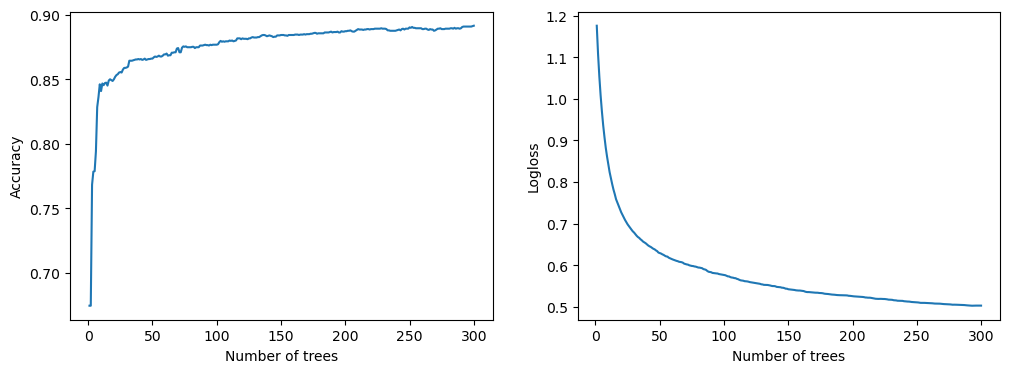

In [20]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

## Predicting on test data and new data

In [21]:
model.predict(test_ds, verbose=0)

array([[0.99723685],
       [0.06328548],
       [0.32470644],
       ...,
       [0.98984855],
       [0.9968645 ],
       [0.6858472 ]], dtype=float32)

In [22]:
pd_dataset = pd.DataFrame({
    "no_of_adults": [2,3,1],
    "no_of_children": [0,1,0],
    "no_of_weekend_nights":[0,1,2],
    "no_of_week_nights":[1,0,1],
    "type_of_meal_plan":["Meal Plan 1","Not Selected","Meal Plan 1"],
    "required_car_parking_space":[0,0,0],
    "room_type_reserved":["Room_Type 1","Room_Type 4","Room_Type 1"],
    "lead_time":[5,22,1],
    "arrival_year":[2018,2017,2018],
    "arrival_month":[4,9,2],
    "arrival_date":[22,13,28],
    "market_segment_type":["Online","Online","Online"],
    "repeated_guest":[0,1,0],
    "no_of_previous_cancellations":[1,0,0],
    "no_of_previous_bookings_not_canceled":[0,5,0],
    "avg_price_per_room":[88.00,94.50,60.00],
    "no_of_special_requests":[1,2,0]
})

new_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pd_dataset)

res = model.predict(new_dataset, verbose=0)
print(res)

for i in res:
    if  i > 0.5:
        print('Booked')
    else:
        print('Not Booked')

[[4.7421705e-02]
 [7.6128921e-04]
 [8.9918864e-01]]
Not Booked
Not Booked
Booked


## Hyper Parameter Tuning

Defined parameters tuning

In [23]:
tuner = tfdf.tuner.RandomSearch(num_trials=25)

"""Define the search space.
Adding more parameters generaly improve the quality of the model, but make
the tuning last longer."""

tuner.choice("min_examples", [2, 5, 7, 10])

"""Some hyper-parameters are only valid for specific values of other
hyper-parameters. For example, the "max_depth" parameter is mostly useful when
"growing_strategy=LOCAL" while "max_num_nodes" is better suited when
"growing_strategy=BEST_FIRST_GLOBAL"."""

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 5, 8])

"""merge=True indicates that the parameter (here "growing_strategy") is already
defined, and that new values are added to it."""

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [32,64,128])

In [24]:
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds)

Use /tmp/tmp6vfcuurk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.951128. Found 30807 examples.
Training model...
Model trained in 0:06:59.961553
Compiling model...


[INFO 2023-03-03T18:14:40.835410316+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6vfcuurk/model/ with prefix 568c81db34a74ca2
[INFO 2023-03-03T18:14:41.005580663+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 48696 node(s), and 17 input feature(s).
[INFO 2023-03-03T18:14:41.005656187+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesOptPred" built
[INFO 2023-03-03T18:14:41.005693727+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [25]:
tuned_model.compile(metrics=["accuracy","AUC","Precision","Recall"])
evaluation = tuned_model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

6/6 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.9007 - auc: 0.9580 - precision: 0.8683 - recall: 0.8190

loss: 0.0000
accuracy: 0.9007
auc: 0.9580
precision: 0.8683
recall: 0.8190


As seen tuning didn't made much difference to the results. Maybe the original sklearn models perform well rather than this but it is just a notebook I made while learning and thought sharing with others.